In [1]:
import torch
import torchvision
from project1_model import project1_model
from torchsummary import summary
from torchtoolbox.transform import CIFAR10Policy
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize
import matplotlib.pyplot as plt

In [2]:
model = project1_model().cuda()
summary(model, input_size=[(3, 32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
      BatchNorm2d-14           [-1, 32,

In [3]:
Epoch = 160
Batch_size = 128
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=3e-4, weight_decay=5e-4)

In [4]:
transform_train = Compose(
        [RandomCrop(32, padding=4), RandomHorizontalFlip(), CIFAR10Policy,
         ToTensor(), Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])])
transform_test = Compose(
        [ToTensor(), Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])])
trainingdata = torchvision.datasets.CIFAR10('./CIFAR10/', train=True, download=True, transform=transform_train)
testdata = torchvision.datasets.CIFAR10('./CIFAR10/', train=False, download=True, transform=transform_test)


trainDataLoader = torch.utils.data.DataLoader(trainingdata, Batch_size, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, Batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

train_loss_history = []
test_loss_history = []
test_acc_history = []

start.record()

for epoch in range(Epoch):
    train_loss = 0.0
    test_loss = 0.0
    test_acc = 0.0

    train_total = 0.0
    test_total = 0.0

    for i, data in enumerate(trainDataLoader):
        x, labels = data
        x = x.cuda()
        train_total+=labels.size(0)
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model(x)
        fit = Loss(predicted_output, labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            x, labels = data
            test_total += labels.size(0)
            x = x.cuda()
            labels = labels.cuda()
            predicted_output = model(x)
            fit = Loss(predicted_output, labels)
            test_loss += fit.item()
            test_acc += (torch.eq(torch.max(predicted_output, 1)[1], labels).sum()).data.cpu().numpy()

    train_loss = train_loss / len(trainDataLoader)
    test_loss = test_loss / len(testDataLoader)
    test_acc = test_acc / test_total

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    print('Epoch %s, Train loss %s, Test loss %s, Test acc %s' % (epoch, train_loss, test_loss, test_acc))

end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

Epoch 0, Train loss 1.7972993472652972, Test loss 1.4183503012113934, Test acc 0.4928
Epoch 1, Train loss 1.3184963193390986, Test loss 1.0781843813159797, Test acc 0.6217
Epoch 2, Train loss 1.0732079492810438, Test loss 0.8540721897837482, Test acc 0.7019
Epoch 3, Train loss 0.9245960162118878, Test loss 0.7533146014696435, Test acc 0.7433
Epoch 4, Train loss 0.8353531728010348, Test loss 0.710666268686705, Test acc 0.7543
Epoch 5, Train loss 0.7597322370237707, Test loss 0.621739223033567, Test acc 0.7883
Epoch 6, Train loss 0.7261249804130906, Test loss 0.6190115892434422, Test acc 0.7894
Epoch 7, Train loss 0.6805170125058849, Test loss 0.5788671740248233, Test acc 0.8041
Epoch 8, Train loss 0.6496311731045813, Test loss 0.530463308095932, Test acc 0.8201
Epoch 9, Train loss 0.6250100396478268, Test loss 0.5271958388105223, Test acc 0.8183
Epoch 10, Train loss 0.6048257940870416, Test loss 0.5197106350826312, Test acc 0.8211
Epoch 11, Train loss 0.581998159208566, Test loss 0.4757

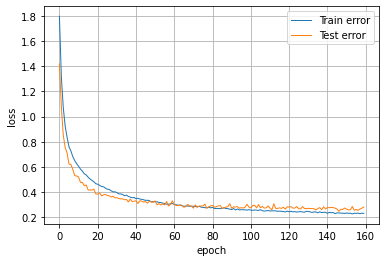

In [6]:
plt.plot(range(Epoch), train_loss_history, '-', linewidth=1, label='Train error')
plt.plot(range(Epoch), test_loss_history, '-', linewidth=1, label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

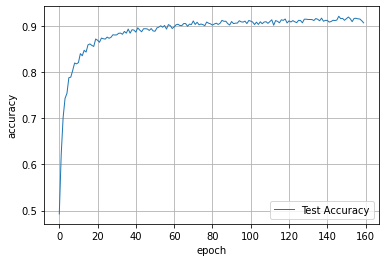

In [7]:
plt.plot(range(Epoch), test_acc_history, '-', linewidth=1, label='Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [8]:
print('Best Test acc: %s' % (max(test_acc_history)))

Best Test acc: 0.9216


In [9]:
model_path = './project1_model.pt'
torch.save(model.state_dict(), model_path)